dpr [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
num_knn [9, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18]


Making predictions:   0%|          | 0/500 [00:01<?, ?it/s]

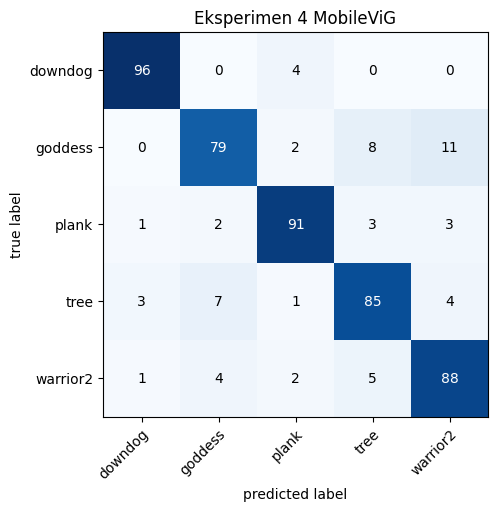

In [1]:
import model_vig

# import model_mobile_vig
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm.auto import tqdm
from pathlib import Path
from torchvision.transforms import v2
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.empty_cache()

test_dir = Path("./data/eksperimen-3/test")
model_path = Path("./models/eksperimen_4_vig.pth")
checkpoint = torch.load(model_path)
state_dict = checkpoint["model_state_dict"]
class_names = ["downdog", "goddess", "plank", "tree", "warrior2"]
# model = model_mobile_vig.mobilevig_ti(num_classes=len(class_names)).to(device)
model = model_vig.vig_ti_224_gelu(num_classes=len(class_names)).to(device)
model.load_state_dict(state_dict=state_dict)
test_preprpocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
test_dataset = datasets.ImageFolder(str(test_dir), transform=test_preprpocess)
class_names = test_dataset.classes
NUM_WORKERS = 4
BATCH_SIZE = 1
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
y_preds = []
wrong_preds = []
false_negatives = {class_name: [] for class_name in class_names}
false_positives = {class_name: [] for class_name in class_names}
lowest_correct_prob = 1.0
lowest_correct_prob_info = None
correct_probs = []
wrong_probs = []
model.eval()
with torch.inference_mode():
    for idx, (X, y) in enumerate(tqdm(test_dataloader, desc="Making predictions")):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_prob = torch.softmax(y_logit, dim=1)
        y_pred = y_prob.argmax(dim=1)
        y_preds.append(y_pred.cpu())
        max_prob = torch.max(y_prob).item()
        if y_pred != y:
            image_path = test_dataset.imgs[idx][0]
            wrong_preds.append((image_path, y.cpu().item(), y_pred.cpu().item()))
            wrong_probs.append(max_prob)
            if len(false_negatives[class_names[y.cpu().item()]]) < 3:
                false_negatives[class_names[y.cpu().item()]].append(
                    (
                        image_path,
                        class_names[y.cpu().item()],
                        class_names[y_pred.cpu().item()],
                        torch.max(y_prob).item(),
                    )
                )
            if len(false_positives[class_names[y_pred.cpu().item()]]) < 3:
                false_positives[class_names[y_pred.cpu().item()]].append(
                    (
                        image_path,
                        class_names[y.cpu().item()],
                        class_names[y_pred.cpu().item()],
                        torch.max(y_prob).item(),
                    )
                )
        else:
            correct_probs.append(max_prob)
            if max_prob < lowest_correct_prob:
                lowest_correct_prob = max_prob
                lowest_correct_prob_info = (
                    test_dataset.imgs[idx][0],
                    class_names[y.cpu().item()],
                    max_prob,
                )

y_pred_tensor = torch.cat(y_preds)
target_tensor = torch.tensor(test_dataset.targets)
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=target_tensor)
confmat_numpy = confmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_numpy,
    class_names=class_names,
    figsize=(5, 5),
    title="Eksperimen 4 MobileViG",
)

Mean probability of correct predictions: 80.45%
Median probability of correct predictions: 86.44%
25th percentile of correct predictions: 70.26%
75th percentile of correct predictions: 93.55%


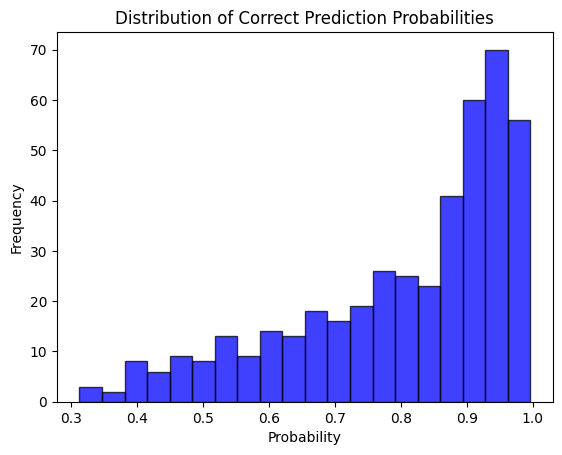

Initial threshold based on the 25th percentile: 70.26%
Lowest probability of correct prediction: 31.33%
Image path: data\eksperimen-3\test\goddess\custom2.jpg
Class: goddess
Average probability of correct predictions: 80.45%


In [2]:
# Convert the list of correct probabilities to a NumPy array for easier analysis
correct_probs = np.array(correct_probs)

# Calculate summary statistics
mean_prob = np.mean(correct_probs)
median_prob = np.median(correct_probs)
percentile_25 = np.percentile(correct_probs, 25)
percentile_75 = np.percentile(correct_probs, 75)

print(f"Mean probability of correct predictions: {mean_prob:.2%}")
print(f"Median probability of correct predictions: {median_prob:.2%}")
print(f"25th percentile of correct predictions: {percentile_25:.2%}")
print(f"75th percentile of correct predictions: {percentile_75:.2%}")

# Plot the distribution of probabilities
plt.hist(correct_probs, bins=20, alpha=0.75, color="blue", edgecolor="black")
plt.title("Distribution of Correct Prediction Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

# Example: Set an initial threshold based on the 25th percentile
threshold = percentile_25
print(f"Initial threshold based on the 25th percentile: {threshold:.2%}")

# Print information about the lowest probability correct prediction
if lowest_correct_prob_info:
    print(f"Lowest probability of correct prediction: {lowest_correct_prob:.2%}")
    print(f"Image path: {lowest_correct_prob_info[0]}")
    print(f"Class: {lowest_correct_prob_info[1]}")

# Print the average probability of correct predictions
if len(correct_probs) > 0:
    average_correct_prob = mean_prob
    print(f"Average probability of correct predictions: {average_correct_prob:.2%}")
else:
    print("No correct predictions to calculate the average probability.")


Mean probability of incorrect predictions: 52.44%
Median probability of incorrect predictions: 49.87%
25th percentile of incorrect predictions: 44.41%
75th percentile of incorrect predictions: 57.68%


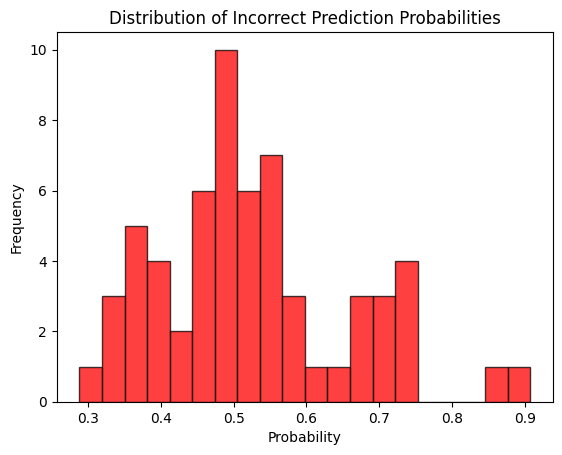

Initial threshold based on the 25th percentile of incorrect predictions: 44.41%
Average probability of incorrect predictions: 52.44%


In [3]:
# Convert the list of wrong probabilities to a NumPy array for easier analysis
wrong_probs = np.array(wrong_probs)

# Calculate summary statistics for wrong probabilities
mean_wrong_prob = np.mean(wrong_probs)
median_wrong_prob = np.median(wrong_probs)
percentile_25_wrong = np.percentile(wrong_probs, 25)
percentile_75_wrong = np.percentile(wrong_probs, 75)

print(f"Mean probability of incorrect predictions: {mean_wrong_prob:.2%}")
print(f"Median probability of incorrect predictions: {median_wrong_prob:.2%}")
print(f"25th percentile of incorrect predictions: {percentile_25_wrong:.2%}")
print(f"75th percentile of incorrect predictions: {percentile_75_wrong:.2%}")

# Plot the distribution of probabilities of incorrect predictions
plt.hist(wrong_probs, bins=20, alpha=0.75, color="red", edgecolor="black")
plt.title("Distribution of Incorrect Prediction Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

# Example: Set an initial threshold based on the 25th percentile for incorrect predictions
wrong_threshold = percentile_25_wrong
print(
    f"Initial threshold based on the 25th percentile of incorrect predictions: {wrong_threshold:.2%}"
)

# Print the average probability of incorrect predictions
if len(wrong_probs) > 0:
    average_wrong_prob = mean_wrong_prob
    print(f"Average probability of incorrect predictions: {average_wrong_prob:.2%}")
else:
    print("No incorrect predictions to calculate the average probability.")


Class: downdog


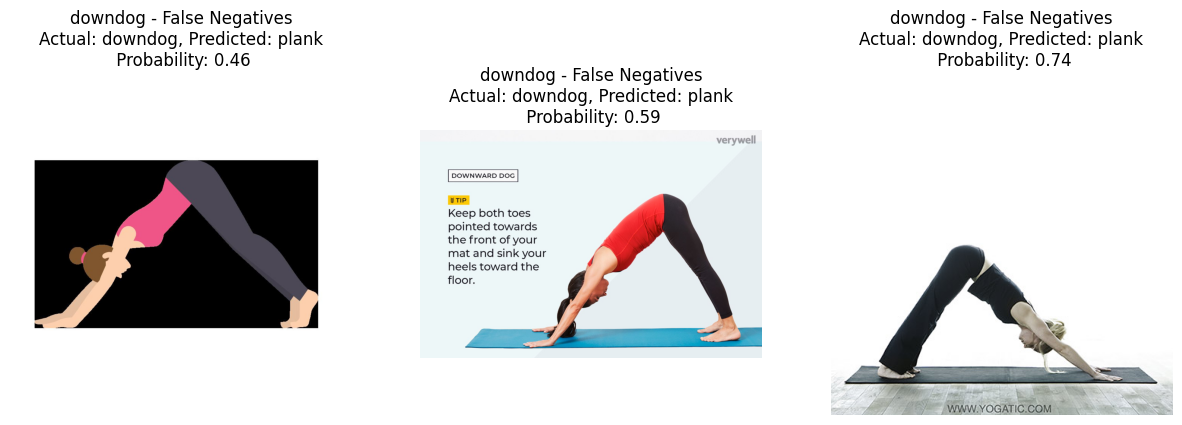

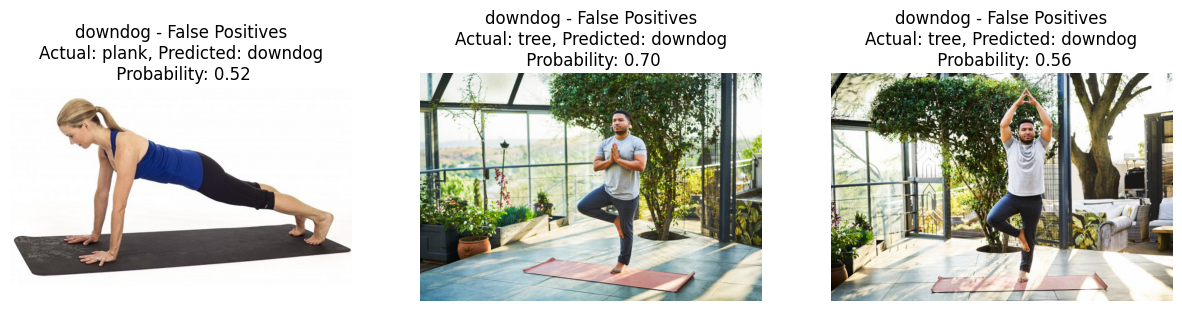

Class: goddess


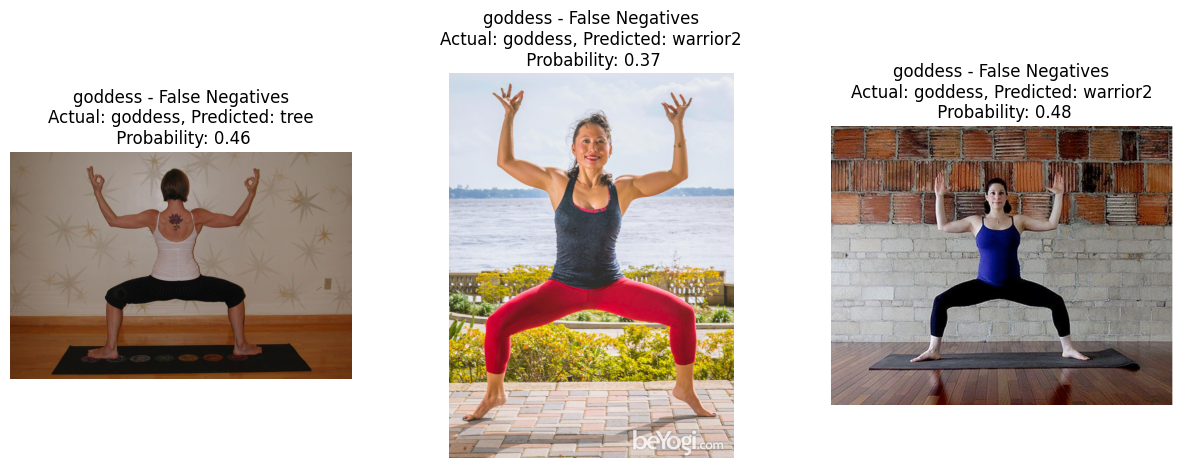

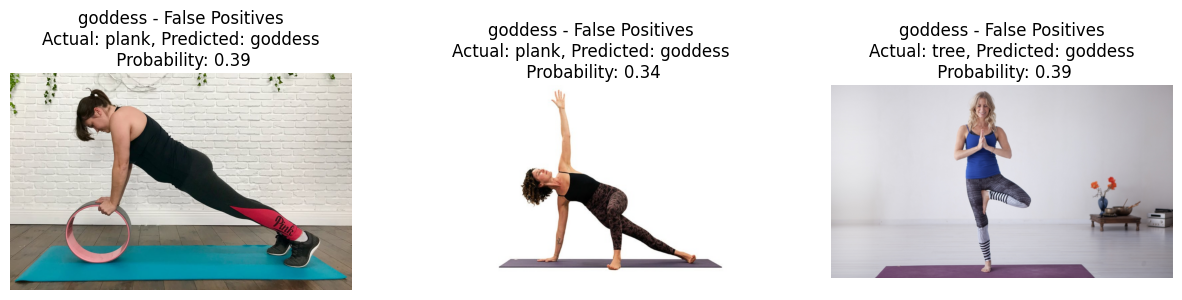

Class: plank


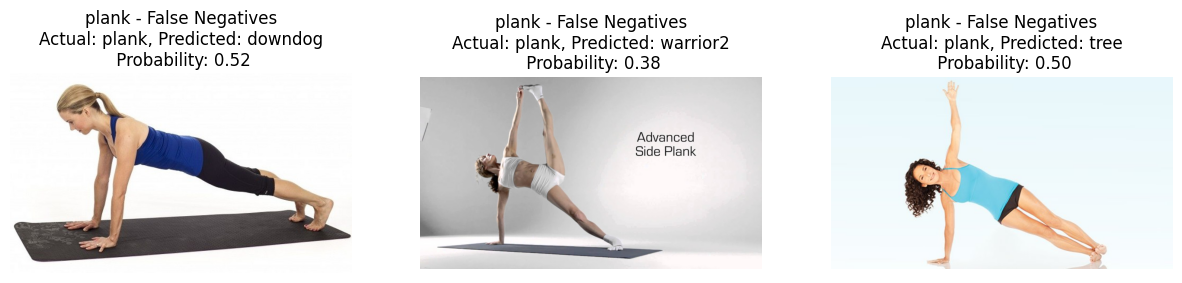

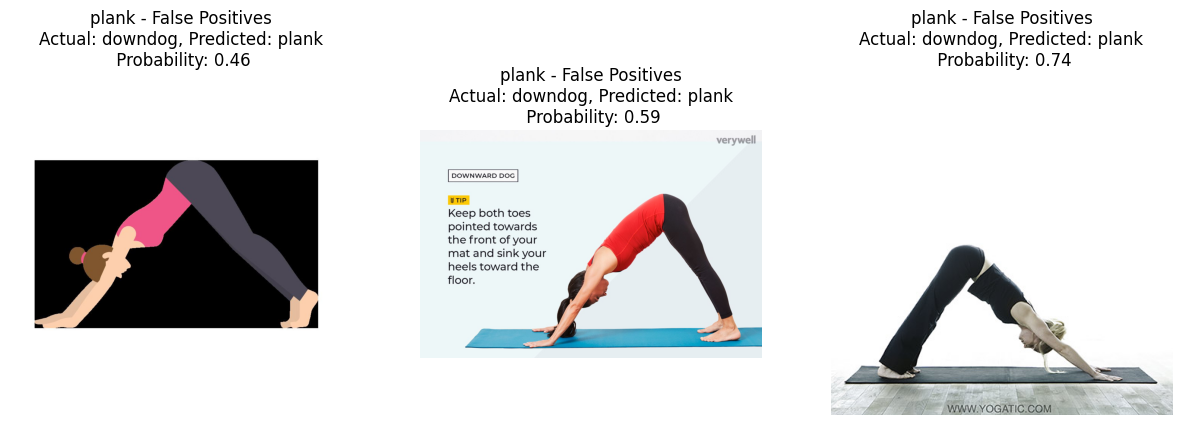

Class: tree


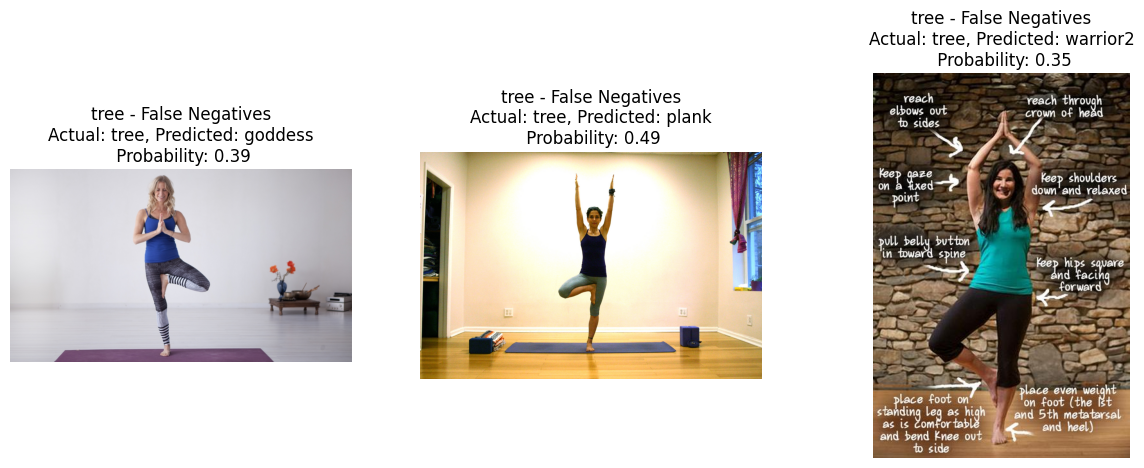

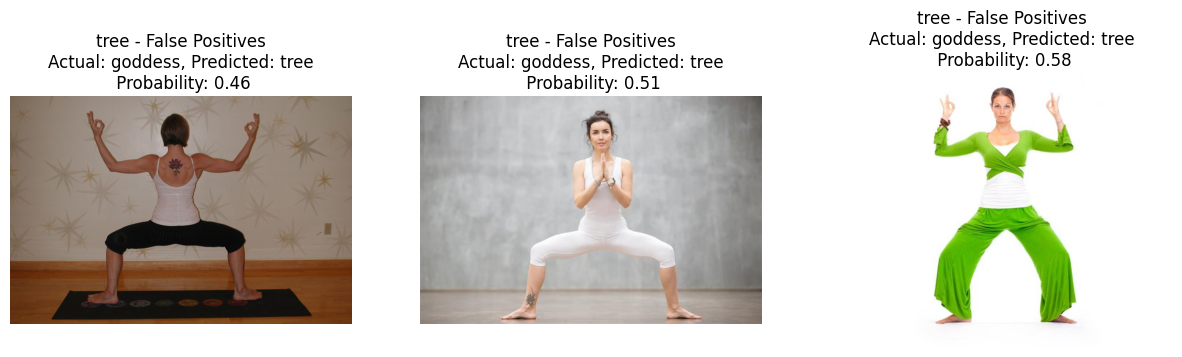

Class: warrior2


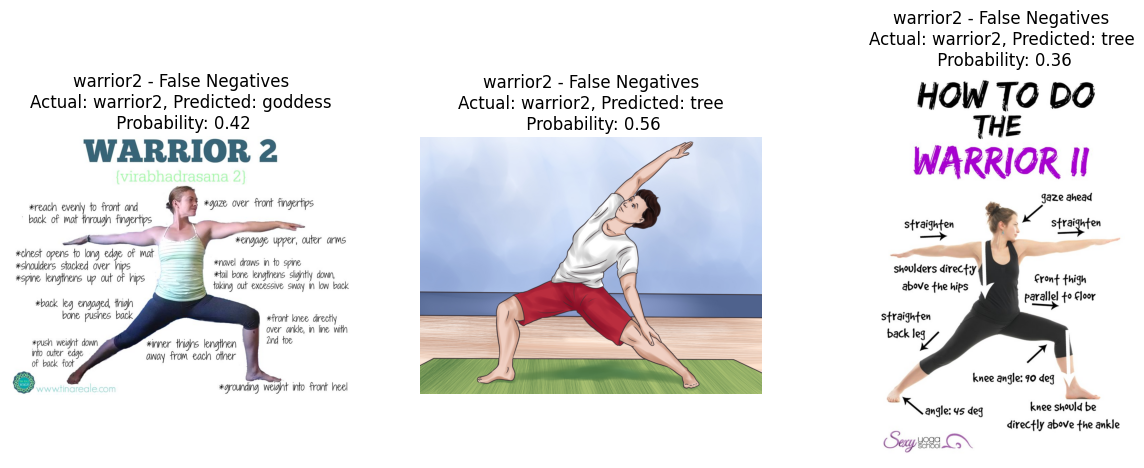

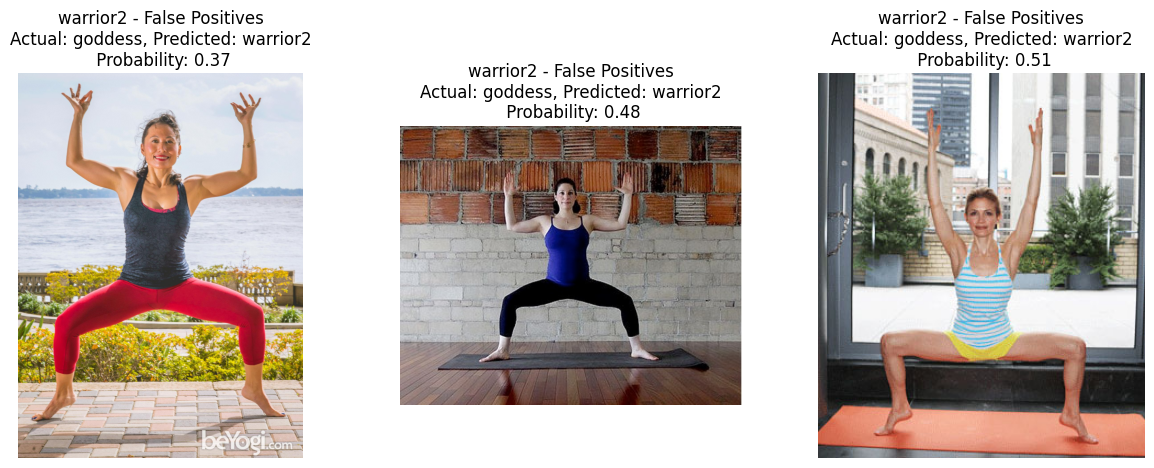

In [4]:
def display_images(image_paths, title_prefix):
    plt.figure(figsize=(15, 5))
    for i, (image_path, actual, predicted, max_prob) in enumerate(image_paths):
        image = Image.open(image_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(
            f"{title_prefix}\nActual: {actual}, Predicted: {predicted}\n Probability: {max_prob:.2f}"
        )
    plt.show()


for class_name in class_names:
    print(f"Class: {class_name}")
    if false_negatives[class_name]:
        display_images(
            false_negatives[class_name],
            title_prefix=f"{class_name} - False Negatives",
        )
    if false_positives[class_name]:
        display_images(
            false_positives[class_name],
            title_prefix=f"{class_name} - False Positives",
        )


In [5]:
from torchmetrics import Precision

precision_fn = Precision(
    num_classes=len(class_names), task="multiclass", average="macro"
)
precision = precision_fn(preds=y_pred_tensor, target=target_tensor)
print(precision)

tensor(0.8782)


In [6]:
from torchmetrics import Recall

recall_fn = Recall(num_classes=len(class_names), task="multiclass", average="macro")
recall = recall_fn(preds=y_pred_tensor, target=target_tensor)
print(recall)

tensor(0.8780)


In [7]:
from torchmetrics import F1Score

f1score_fn = F1Score(num_classes=len(class_names), task="multiclass", average="macro")
f1score = f1score_fn(preds=y_pred_tensor, target=target_tensor)
print(f1score)

tensor(0.8777)


In [8]:
torch.cuda.empty_cache()

In [9]:
# import matplotlib.pyplot as plt
# from PIL import Image

# # Plot wrong predictions
# plt.figure(figsize=(15, 15))
# for i, (image_path, true_label, pred_label) in enumerate(wrong_preds):
#     plt.subplot(
#         5, 5, i + 1
#     )  # Adjust the subplot grid size based on the number of wrong predictions
#     img = Image.open(image_path)
#     plt.imshow(img)
#     plt.title(
#         f"True: {class_names[true_label.item()]}\nPred: {class_names[pred_label.item()]}"
#     )
#     plt.axis("off")
#     if i == 24:  # Display a maximum of 25 wrong predictions
#         break
# plt.tight_layout()
# plt.show()